# The Vertical Scaleheight of the Interstellar Medium

## Oshri Fatkiev

If we observe the different gas phases at the solar neighborhood in a direction
perpendicular to the disk, we can estimate the atmospheric weight by the
material and compare to the observed pressure gradient there.

In this notebook we will analyze the vertical structure of the ISM and demonstrate that there is an inconsistency – the pressure is not nearly enough to balance the
weight.

This notebook follows an analysis shown in Cox 2005, section 2:
https://www.annualreviews.org/doi/abs/10.1146/annurev.astro.43.072103.150615

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [ ]:
# Constants (CGS units)
PC_TO_CM = 3.08567758e18
proton_mass = 1.6726e-24
k_boltzmann = 1.380649e-16
G = 6.6743e-8

In [ ]:
# Phases in (1/cm^3)
molecular = lambda z: 0.58 * np.exp(-(z/81)**2)
cold_HI = lambda z: 0.57 * 0.7 * np.exp(-(z/127)**2)
warm_HIa = lambda z: 0.57 * 0.18 * np.exp(-(z/318)**2)
warm_HIb = lambda z: 0.57 * 0.11 * np.exp(-np.abs(z)/403)
HII_regions = lambda z: 0.015 * np.exp(-np.abs(z)/70)
HII_diffuse = lambda z: 0.025 * np.exp(-np.abs(z)/1000)
stars_dm = lambda z: 1.5 * np.exp(-(np.abs(z)/300)**0.5)

In [ ]:
X_HE = 0.1  # Helium fraction

total_number_density = lambda z: (molecular(z) + cold_HI(z) + warm_HIa(z) +
                            warm_HIb(z) + HII_regions(z) + HII_diffuse(z) +
                            stars_dm(z))

gas_number_density = lambda z: (molecular(z) + cold_HI(z) + warm_HIa(z) +
                            warm_HIb(z) + HII_regions(z) + HII_diffuse(z))

In [ ]:
upper_bound = 10000 # 10 kpc
x = np.arange(upper_bound)

### The vertical distribution of the phases between $0$ and $3$ kpc

First, let's plot each of the number densities $n$ seperatly, as a function of the vertical distance from the disk $z$

In [ ]:
phases = {
    molecular:'Molecular',
    cold_HI:'Cold HI',
    warm_HIa:'Warm HI(a)',
    warm_HIb:'Warm HI(b)',
    HII_regions:'HII regions',
    HII_diffuse:'HII diffuse',
    stars_dm:'Stars and DM'
    }

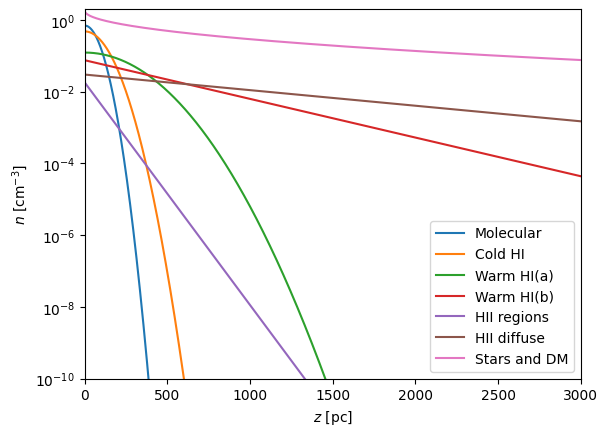

In [ ]:
for f, name in phases.items():
  n = (1 + 2 * X_HE) * f(x)
  plt.semilogy(x, n, label=name)

plt.xlabel(r'$z\ \left[\mathrm{pc}\right]$')
plt.ylabel(r'$n\ \left[\mathrm{cm^{-3}}\right]$')
plt.ylim([10**-10, 2])
plt.xlim([0, 3000])
plt.legend()
plt.show()

### The total density of gas

Next, we can add up all the number densities related to the gas and plot the total density of the gas $\rho$ as a function of the vertical distance $z$

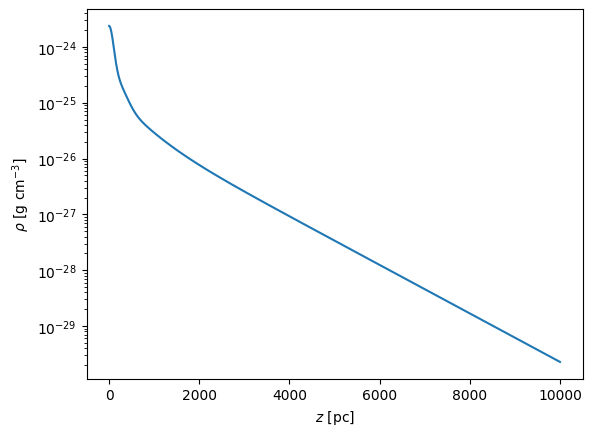

In [ ]:
gas_density = lambda z: proton_mass * (1 + 2 * X_HE) * gas_number_density(z)

plt.semilogy(x, gas_density(x))

plt.xlabel(r'$z\ \left[\mathrm{pc}\right]$')
plt.ylabel(r'$\rho\ \left[\mathrm{g\ cm^{-3}}\right]$')
plt.show()

### The pressure of the gaseous phases

To compute the total pressure of the gaseous phases, we start by using the *full mixing approximation* - each phase
occupies the entire volume and the total pressure is the sum of the relative
pressures.

The pressure of each phase is calculated according to the ideal gas equation of state,

$$𝑃=𝑛 𝑘_B 𝑇$$

with $𝑃,\ 𝑛,\ 𝑇\ $ the pressure, number density and temperature of
the gas in each phase respectively.

In [ ]:
temperatures = {
    molecular:15,
    cold_HI:80,
    warm_HIa:5000,
    warm_HIb:8000,
    HII_regions:7500,
    HII_diffuse:9000
    }

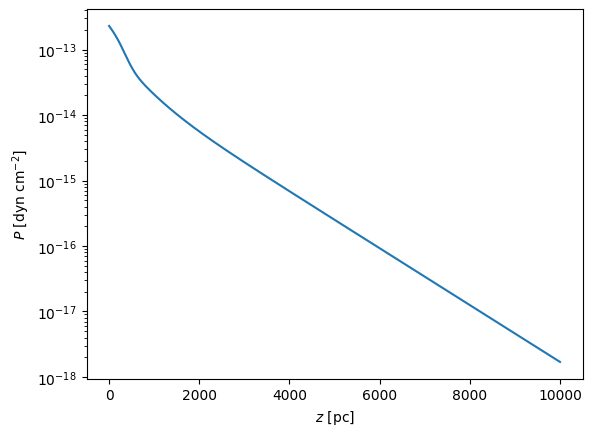

In [ ]:
gas_pressure = np.zeros(upper_bound)

for gas, temp in temperatures.items():
  n = (1 + 2 * X_HE) * gas(x)
  gas_pressure += n * k_boltzmann * temp

plt.semilogy(x, gas_pressure)

plt.xlabel(r'$z\ \left[\mathrm{pc}\right]$')
plt.ylabel(r'$P\ \left[\mathrm{dyn\ cm^{-2}}\right]$')
plt.show()

### The total gravity as a function of $z$

Using the *Poisson equation* i.e.,

$$ \nabla^{2}\Phi=4\pi G\rho $$

let's calculate the total gravity. Assuming the disk is an infinite slab, from the symmetry of the system $\nabla^{2}= \partial^2/\partial z^{2}$ therefore

$$ \frac{\partial^2}{\partial z^{2}}\Phi=4\pi G\rho $$

and by integrating both sides once we get

$$ \frac{\partial}{\partial z}\Phi=4\pi G\int_{-z}^{z}\rho\left(z^{\prime}\right)dz^{\prime} $$

Now, as we know $g=-\nabla\Phi$ we can write

$$ \vec{g}\left(z\right) = -\hat{z}4\pi G\int_{-z}^{z}\rho\left(z^{\prime}\right)dz^{\prime} $$

thus

$$ \boxed{g\left(z\right) = 4\pi G\int_{-z}^{z}\rho\left(z^{\prime}\right)dz^{\prime} }$$

Solving the integral numerically and plotting the total gravity $g\left(z\right)$ we obtain

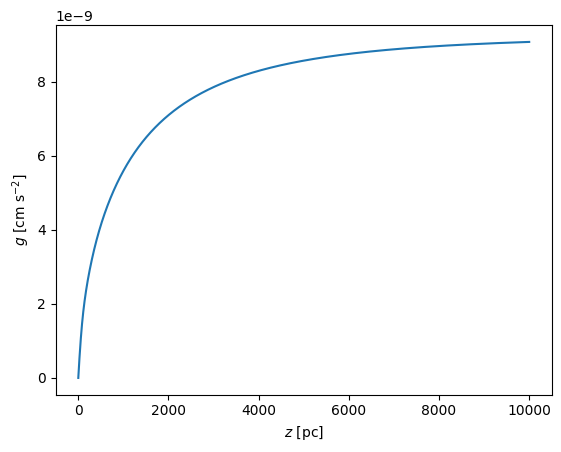

In [ ]:
gravity = np.zeros(upper_bound)

for i in x:
    res, _ = quad(total_number_density, -i, i)
    gravity[i] = 4 * np.pi * G * proton_mass * res * PC_TO_CM

plt.plot(x, gravity)

plt.xlabel(r'$z\ \left[\mathrm{pc}\right]$')
plt.ylabel(r'$g\ \left[\mathrm{cm\ s^{-2}}\right]$')
plt.show()

### The pressure needed to balance the gravity

Using *Newton's 2nd law*,

$$ \nabla P=-\rho g $$

To get the pressure from $\nabla P$ we will set $P\left(10\ \mathrm{kpc}\right)=0$ and integrate inwards, so

$$ \int_{z}^{10\ \mathrm{kpc}}\nabla Pdz^{\prime}=P\left(10\ \mathrm{kpc}\right) - P\left(z\right)=-P\left(z\right) $$

and therefore

$$ \boxed{ P\left(z\right)=\int_{z}^{10\ \mathrm{kpc}}\rho(z^{\prime})g(z^\prime)dz^{\prime}} $$

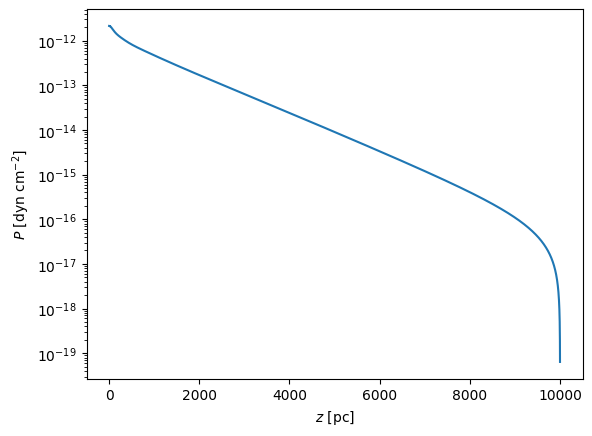

In [ ]:
equil_pressure = np.zeros(upper_bound)

g = interp1d(x, gravity, fill_value='extrapolate')

integrand = lambda z: gas_density(z) * g(z)

for i in x:
    res, _ = quad(integrand, i, 1e4)
    equil_pressure[i] = res * PC_TO_CM  # so dz will have units of cm

plt.semilogy(x, equil_pressure)

plt.xlabel(r'$z\ \left[\mathrm{pc}\right]$')
plt.ylabel(r'$P\ \left[\mathrm{dyn\ cm^{-2}}\right]$')
plt.show()

Finally, we can compare both of the pressure we computed above - `equil_pressure` and `gas_pressure`:

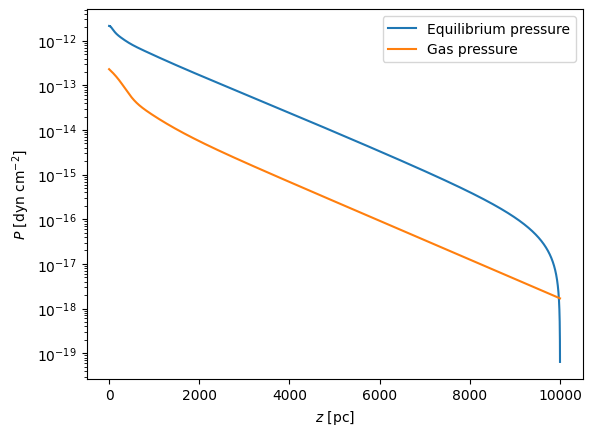

In [ ]:
plt.semilogy(x, equil_pressure, label='Equilibrium pressure')
plt.semilogy(x, gas_pressure, label='Gas pressure')

plt.xlabel(r'$z\ \left[\mathrm{pc}\right]$')
plt.ylabel(r'$P\ \left[\mathrm{dyn\ cm^{-2}}\right]$')
plt.legend()
plt.show()

As we can clearly see, there is about one order of magnitude difference between the two, which means that the gas thermal pressure is at most $1/10$ of the total vertical pressure needed for equilibrium between the gravity and the pressure.

The rest of the pressure comes from non-thermal components such as magnetic fields, cosmic rays and turbulence.